# Spam Filter using the Multinomial Naive Bayes algorithm

The Naive Bayes classifier is a supervised machine learning algorithm, which is commonly applied in use cases involving recommendation systems, text classification, and sentiment analysis. Because it performs well with data sets with high dimensionality, it is a favored classifier for text classification in particular.

Naive Bayes (NB) is also a generative learning algorithm, which means that it models the distribution of data points for a given class or category. This probabilistic classifier is based off of Bayes' Theorem, meaning that this Bayesian classifier uses conditional probabilities and prior probabilities to calculate the posterior probabilities.

Naive Bayes classifiers work differently in that they operate under a couple of key assumptions, earning it the title of naive. It assumes that predictors in a Naive Bayes model are conditionally independent, or unrelated to any of the other feature in the model. It also assumes that all features contribute equally to the outcome.

While these assumptions are often violated in real-world scenarios (for example, a subsequent word in an e-mail is dependent upon the word that precedes it), it simplifies a classification problem by making it more computationally tractable. That is, only a single probability will now be required for each variable, which, in turn, makes the model computation easier. Despite this unrealistic independence assumption, the classification algorithm performs well, particularly with small sample sizes.

## Step 1: Install and import relevant libraries

We'll need a few libraries for this tutorial. Make sure to import the ones below, and if they're not installed, you can resolve this with a quick pip install.

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Step 2: Load the data

For this tutorial, we will be using a spam data set from the UCI Machine Learning Repository to walk through a classic spam filtering use case for Naive Bayes.

In [123]:
df = pd.read_csv("spam.csv", encoding = "latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Step 3: Conduct an exploratory data analysis

Before preprocessing, it’s always good to organize the data and examine it for any underlying issues, such as missing or duplicate data. Plotting the data can also help us to see if the data is balanced.

Let's start by recoding our class labels from their categorical form, such as "spam" and "ham" to a numerical format using 1's and 0's.

In [124]:
df = df.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"],axis=1)
df.rename(columns= { 'v1' : 'class' , 'v2' : 'message'}, inplace= True)
df.head()

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [125]:
#recoding dataset
df['target'] = np.where(df['class']=='ham',0, 1)

In [126]:
#check for duplicate data
df['duplicates'] = np.where(df['message'].duplicated(keep=False), 1, 0)

In [127]:
print('Top 5 common duplicate texts are:')
df[df.duplicates == 1].pivot_table(index='message', values='target', aggfunc='count').sort_values(by='target', ascending=False).head(5)

Top 5 common duplicate texts are:


,target
message,
"Sorry, I'll call later",30
I cant pick the phone right now. Pls send a message,12
Ok...,10
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4


In [128]:
#check for missing data
print("Missing data in each column:\n" + str(df.isnull().sum()))

Missing data in each column:
class         0
message       0
target        0
duplicates    0
dtype: int64


In [129]:
df['target'].value_counts()

,count
target,
0,4825
1,747


<ipython-input-130-14c175923da9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = df['class'], palette = 'rocket')


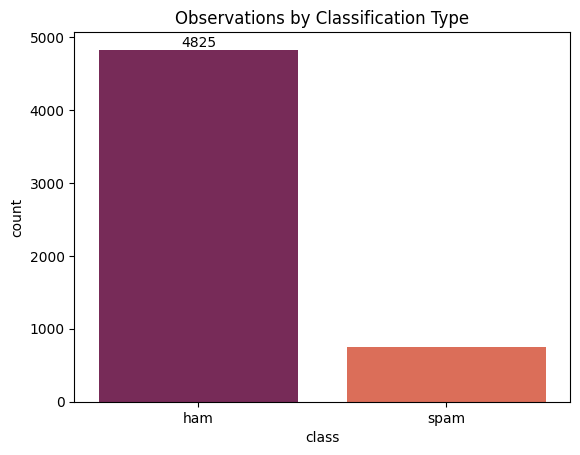

In [130]:
# Explore distribution of dataset

# count plot on single categorical variable
ax = sns.countplot(x = df['class'], palette = 'rocket')

#add data labels
ax.bar_label(ax.containers[0])

# add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

While there is no missing data, there is duplicate data in this data set. Additionally, the plot indicates that the class distribution is uneven with spam representing only 13% of the data. So, we have an imbalanced dataset, which can be a concern as it can lead to overfitting. While it does not mean that the training data will overfit, it is good to be aware of this upfront in case we need to use over-sampling (also known as upsampling) or under-sampling (also known as downsampling) techniques. With this in mind, we'll drop the duplicate data and proceed with training our model on this imbalanced distribution first.

In [131]:
# Dropping all duplicate texts based off of results of EDA
df_no_dup = df.drop_duplicates(subset=['message'], keep='first')

<ipython-input-132-25ccc436ab16>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = df_no_dup['class'], palette = 'rocket')


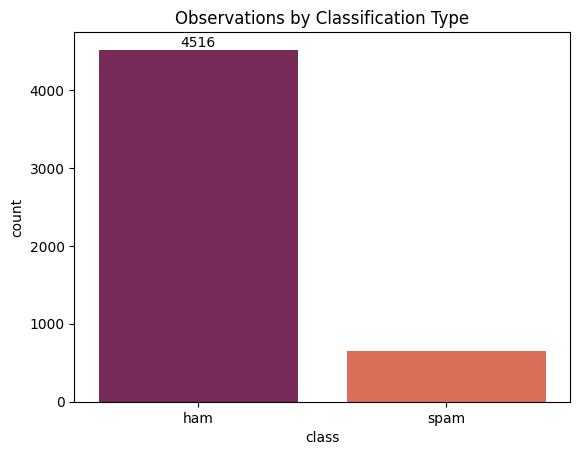

In [132]:
# Explore distribution of dataset

# count plot on single categorical variable
ax = sns.countplot(x = df_no_dup['class'], palette = 'rocket')

#add data labels
ax.bar_label(ax.containers[0])

# add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

## Step 4: Split your data

Next, we will split our data set into two groups, a training set and a test set. The training data will help us train our Naive Bayes model and our test data will help us to evaluate its performance. The test data set will be 30% of our initial data set, but you can adjust this by changing the value of the test_size parameter.

In [133]:
#let's seperate the output and documents
X = df["message"].values
y = df["target"].values

In [134]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Step 5: Preprocess the data

After we split the data, we can start preprocessing it. This includes natural language processing tasks, such as tokenization, stop-word removal, stemming, and lemmatization.

Then, we will use a popular word embedding technique, called bag-of-words, to extract features from the text. This technique specifically calculates the frequency of words within a given document, which can help us classify documents, assuming that similar documents have similar content.

We can use scikit-learn's CountVectorizer or TfidfVectorizer to do the heavy lifting for us here.

In [135]:
def text_clean(text, method, rm_stop):
    text = re.sub(r"\n","",text)   #remove line breaks
    text = text.lower() #convert to lowercase
    text = re.sub(r"\d+","",text)   #remove digits and currencies
    text = re.sub(r'[\$\d+\d+\$]', "", text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)   #remove dates
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'[^\x00-\x7f]',r' ',text)   #remove non-ascii
    text = re.sub(r'[^\w\s]','',text)   #remove punctuation
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)   #remove hyperlinks

    #remove stop words
    if rm_stop == True:
        filtered_tokens = [word for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
        text = " ".join(filtered_tokens)

    #lemmatization: typically preferred over stemming
    if method == 'L':
        lemmer = WordNetLemmatizer()
        lemm_tokens = [lemmer.lemmatize(word) for word in word_tokenize(text)]
        return " ".join(lemm_tokens)

    #stemming
    if method == 'S':
        porter = PorterStemmer()
        stem_tokens = [porter.stem(word) for word in word_tokenize(text)]
        return " ".join(stem_tokens)

    return text

<img src="">



### Lemmatization

<img src="https://cdn.botpenguin.com/assets/website/Lemmatization_5338fc7c3e.png">

Lemmatization is a linguistic process that involves reducing words to their base or dictionary form, which is known as a lemma. This process helps simplify textual analysis by grouping together variants of a word.

Lemmatization goes beyond simple word reduction and considers the context of a word in a sentence. It analyzes the part of speech and meaning to accurately convert words to their base form.

A lemma is the base form or dictionary form of a word. It acts as the standard form under which all variants of a word are grouped.

In [136]:
#preprocessed data: Lemm + stopword removal
preprocessed_text_1 = [text_clean(text, 'L', True) for text in X_train]

#preprocessed data: Lemm + no stopword removal
preprocessed_text_2 = [text_clean(text, 'L', False) for text in X_train]


### Stemming

<img src="https://cdn.botpenguin.com/assets/website/Stemming_53678d43bc.png">

Stemming is a technique used in Natural Language Processing (NLP) that involves reducing words to their base or root form, called stems.

Let's take an example. Consider the words "changing", "changed", and "change".

Notice any similarity?

Right - they all originate from the root word - "change". Stemming helps us strip each of these words down to their 'stem' - "change".

The magic here is that it can simplify analysis or processing by reducing words to their common base.

However, Stemming isn't always perfect. It can sometimes be too aggressive, chopping off parts of words leaving stems that are not grammatically correct.

For instance, "argue", "arguing", "argued" might be reduced to the stem "argu".

In [ ]:
#preprocessed data: Stem + stopword removal
preprocessed_text_3 = [text_clean(text, 'S', True) for text in X_train]

#preprocessed data: Stem + no stopword removal
preprocessed_text_4 = [text_clean(text, 'S', False) for text in X_train]

### Stemming versus Lemmatization

Stemming and lemmatization are both ways to reduce words to their root form.

Stemming might not always return an actual word. For instance, 'running' could be stemmed to 'runn', which is not a meaningful word in English.

But lemmatization ensures the root word is a real word, like 'run', taking the grammatical structure into consideration.

## Step 6: Optimize and evaluate your Multinomial Naive Bayes model

Because we can process the data in a number of ways, we should model different versions of preprocessed data to understand which variation of data provides the optimal results within our model. For this use case, we will be using the most popular NB classifier, Multinomial Naive Bayes, as it is most commonly used for classification tasks, such as document classification. This variant is useful when using discrete data, such as frequency counts, and it is typically applied within natural language processing use cases.

After we apply the Multinomial Naive Bayes model to our different variants of training data, we can evaluate performance of the estimator using the testing data.

In [137]:
def transform_model_data_w_count_vectorizer(preprocessed_text, Y_train,  X_test, Y_test):
    #vectorize dataset
    vectorizer = CountVectorizer()
    vectorized_data = vectorizer.fit_transform(preprocessed_text)

    #define model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)

    #evaluate model
    predictions = model.predict(vectorizer.transform(X_test))
    accuracy = accuracy_score( Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    print("Accuracy:",round(100*accuracy,2),'%')
    print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
    print("Precision:", round(100*precision,2),'%')
    return predictions, model

In [138]:
def transform_model_data_w_tfidf_vectorizer(preprocessed_text, Y_train,  X_test, Y_test):
    #vectorize dataset
    tfidf = TfidfVectorizer()
    vectorized_data = tfidf.fit_transform(preprocessed_text)

    #define model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)

    #evaluate model
    predictions = model.predict(tfidf.transform(X_test))

    accuracy = accuracy_score( Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    print("Accuracy:",round(100*accuracy,2),'%')
    print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
    print("Precision:", round(100*precision,2),'%')
    return predictions, model

In [139]:
#vectorize, model, and evaluate model using CountVectorizer

#Lemm + stopword removal
print("Lemm + stopword removal + CountVectorizer")
transform_model_data_w_count_vectorizer(preprocessed_text_1, Y_train,  X_test, Y_test)

#Lemm + no stopword removal
print("\nLemm + no stopword removal + CountVectorizer")
transform_model_data_w_count_vectorizer(preprocessed_text_2, Y_train,  X_test, Y_test)

#Stem + stopword removal
print("\nStem + stopword removal + CountVectorizer")
transform_model_data_w_count_vectorizer(preprocessed_text_3, Y_train,  X_test, Y_test)

#Stem + no stopword removal
print("\nStem + no stopword removal + CountVectorizer")
transform_model_data_w_count_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test)

Lemm + stopword removal + CountVectorizer
Accuracy: 97.97 %
Balanced accuracy: 95.49 %
Precision: 93.59 %

Lemm + no stopword removal + CountVectorizer
Accuracy: 97.91 %
Balanced accuracy: 94.92 %
Precision: 94.32 %

Stem + stopword removal + CountVectorizer
Accuracy: 97.01 %
Balanced accuracy: 91.42 %
Precision: 94.76 %

Stem + no stopword removal + CountVectorizer
Accuracy: 97.85 %
Balanced accuracy: 93.84 %
Precision: 96.33 %


(array([0, 0, 0, ..., 0, 0, 0]), MultinomialNB(alpha=0.1))

In [140]:
#vectorize, model, and evaluate model using TfidfVectorizer

#Lemm + stopword removal
print("Lemm + stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_1, Y_train,  X_test, Y_test)

#Lemm + no stopword removal
print("\nLemm + no stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_2, Y_train,  X_test, Y_test)

#Stem + stopword removal
print("\nStem + stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_3, Y_train,  X_test, Y_test)

#Stem + no stopword removal
print("\nStem + no stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test)

Lemm + stopword removal + TfidfVectorizer
Accuracy: 97.49 %
Balanced accuracy: 92.4 %
Precision: 96.67 %

Lemm + no stopword removal + TfidfVectorizer
Accuracy: 97.61 %
Balanced accuracy: 92.12 %
Precision: 98.53 %

Stem + stopword removal + TfidfVectorizer
Accuracy: 95.39 %
Balanced accuracy: 84.35 %
Precision: 98.2 %

Stem + no stopword removal + TfidfVectorizer
Accuracy: 95.93 %
Balanced accuracy: 86.06 %
Precision: 98.85 %


(array([0, 0, 0, ..., 0, 0, 0]), MultinomialNB(alpha=0.1))

In [141]:
predictions, model = transform_model_data_w_tfidf_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test)

Accuracy: 95.93 %
Balanced accuracy: 86.06 %
Precision: 98.85 %


While the accuracy score is typically the favored evaluation metric for classification tasks, we will want to focus on precision as our primary evaluation metric; otherwise, we might fall victim to the accuracy paradox.

When data sets are unbalanced, like this sample one is, the accuracy score could be a misleading metric for evaluation. Precision, on the other hand, will help us minimize the number of false positives (that is, the number of non-spam texts that end up in spam).

Accuracy score is defined as:

$$
\frac{true negative + true positive} {true negative + false positive + true positive + false negative}
$$

Precision is defined as:

$$
\frac{true positive} {true positive + false positive}
$$

A confusion matrix can help us visualize these metrics more easily.



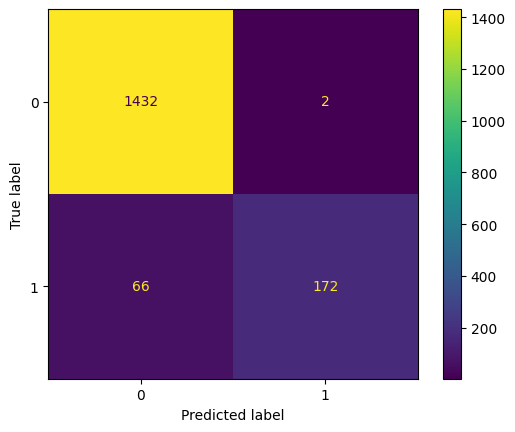

In [143]:
# compute the confusion matrix.
cm = confusion_matrix(Y_test, predictions)

 #Plot the confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
